# **Warning: to run this notebook you need to have a OpenAI API key!**

# Describe the clustering based on :
1) **Facility RAW counts** 
2) **counts NORMALIZED with POPULATION data**
3) **counts NORMALIZED with MIN.-MAX.**

- Following Ekaterina's advice, we produced the dataframes "facilities per neighborhood" in three different versions : raw counts, counts per 10000 inhabitants, counts scaled with min-max, and fed them to Chat GPT with different prompting. The aim was to get 5 adjectives describing the atmosphere/vibe of the neighborhood, adjectives which could potentially be used further for classifying the neighborhood. Using three versions of the dataframe aimed at checking how the normalization would be affecting the description. Frankly, not so sure whether that was really helpful.
- First attempt: simply the above mentionned counts.
- Second attempt: **adding info on population and address**, and asked ChatGPT to consider this info as well. The adjectives were more sensible, but still I'm not so sure how we should use these results.  This second attempt goes in the direction of "get more data to better describe the neighborhood", which seems logical...
- Third attempt: ask to do a clustering, and explianing on which basis. Since i let population and location in the dataframes, the clustering was obvious... => based on pop data and location, with a clear separation rural/city.
- **4th and last attempt: clustering tasks with justification, but without any info on population size and address. Interesting: the groups tend to be different depending on the normalization used. Also, the groups are different from one query to another (made 3 in total), indicatiing that the results of ChatGPT are not very reproducible, even with a temperature of zero**. The criteria/concepts/ideas which seem to be mostly used are: 
    - Amenity Diversity
    - Accessibility
    - Community Services
    - Fitness/Wellness and Education
    - Urban Connectivity


All result files were originally here:  notebooks\01_Data_visualization\Describe_Cluster_Outputs but are currently in ".ARCHIVE"

Further on the normalization issue: 
- I plotted the data to compare what we get with each scenario.   
- I'm not convinced (at least with so little data) that the min-max scaling is ideal, since in many instances the min disappears (is necessarily set to zero!), which seems to me also wrong.  
- Regarding normalization with population, it's interesting to see that the rural areas are much better off!!!

# Dependencies

In [26]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import json
import os
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import locale
import yaml
import openai

# Load data

In [5]:
def load_data(path):
    try: 
        with open(path, 'r') as file:
            data = json.load(file)
        return data
    except Exception as e:
        print(f"An error as occured: {e}")
        
def get_file_names(directory):
    return [
        os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.json')
    ]

In [9]:
directory = r"../data/google_data_isochrone_pop_cgpt"
FILES = get_file_names(directory)
FILES

['../data/google_data_isochrone_pop_cgpt\\Ex1_8004_Zurich_Werdgartengasse_4.json',
 '../data/google_data_isochrone_pop_cgpt\\Ex2_3027_Bern_Colombstrasse_39.json',
 '../data/google_data_isochrone_pop_cgpt\\Ex3_1006_Lausanne_Av_d_Ouchy_58.json',
 '../data/google_data_isochrone_pop_cgpt\\Ex4_8355_Aadorf_Bruggwiesenstrasse_5.json',
 '../data/google_data_isochrone_pop_cgpt\\Ex5_6319_Allenwinden_Winzruti_39.json',
 '../data/google_data_isochrone_pop_cgpt\\Ex6_8005_Zurich_Heinrichstrasse_200.json',
 '../data/google_data_isochrone_pop_cgpt\\Ex7_8003_Zurich_Birmensdorferstrasse_108.json']

In [10]:
# get Constructor Academy:
CONSAC = load_data(FILES[5]) 
CONSAC['original_address']

{'address': '8005 Zürich, Heinrichstrasse 200',
 'coordinates': [47.3877722, 8.5254298]}

## Create dataframes

In [11]:
neighborhoods = {}
i=0  # used as index 

for file in FILES:
    example = load_data(file)
    record={'address':example['original_address']['address'],
                    'lat':example['original_address']['coordinates'][0] , 
                    'lon':example['original_address']['coordinates'][1],
                    'total_pop': example['population']['total_pop'], 
                    'zip_city': example['original_address']['address'].split(',')[0]}
    for facilty_type in example['facilities'].keys():
        record[facilty_type] = example['facilities'][facilty_type]['count']
    print(record)
    neighborhoods[i] = record # adds the record (one neighborhood) to the full dictionnary. the i will be used as index in the DataFrame
    i+=1

neighborhoods = pd.DataFrame.from_dict(neighborhoods, orient='index')
neighborhoods


{'address': '8004 Zürich, Werdgartengasse 4', 'lat': 47.3711263, 'lon': 8.5265537, 'total_pop': 20076, 'zip_city': '8004 Zürich', 'bars': 4, 'restaurants': 9, 'kindergarten': 6, 'public_transportation': 34, 'gym_fitness': 14, 'grocery_stores_supermarkets': 14, 'gas_ev_charging': 4, 'schools': 6}
{'address': '3027 Bern, Colombstrasse 39', 'lat': 46.9455907, 'lon': 7.3777487, 'total_pop': 8419, 'zip_city': '3027 Bern', 'bars': 4, 'restaurants': 20, 'kindergarten': 20, 'public_transportation': 22, 'gym_fitness': 14, 'grocery_stores_supermarkets': 18, 'gas_ev_charging': 12, 'schools': 3}
{'address': "1006 Lausanne, Av. d'Ouchy 58", 'lat': 46.5087576, 'lon': 6.627395399999999, 'total_pop': 9994, 'zip_city': '1006 Lausanne', 'bars': 12, 'restaurants': 12, 'kindergarten': 22, 'public_transportation': 28, 'gym_fitness': 15, 'grocery_stores_supermarkets': 15, 'gas_ev_charging': 14, 'schools': 5}
{'address': '8355 Aadorf, Bruggwiesenstrasse 5', 'lat': 47.4929713, 'lon': 8.8935522, 'total_pop': 2

,address,lat,lon,total_pop,zip_city,bars,restaurants,kindergarten,public_transportation,gym_fitness,grocery_stores_supermarkets,gas_ev_charging,schools
0,"8004 Zürich, Werdgartengasse 4",47.371126,8.526554,20076,8004 Zürich,4,9,6,34,14,14,4,6
1,"3027 Bern, Colombstrasse 39",46.945591,7.377749,8419,3027 Bern,4,20,20,22,14,18,12,3
2,"1006 Lausanne, Av. d'Ouchy 58",46.508758,6.627395,9994,1006 Lausanne,12,12,22,28,15,15,14,5
3,"8355 Aadorf, Bruggwiesenstrasse 5",47.492971,8.893552,2321,8355 Aadorf,3,5,28,15,18,15,16,0
4,"6319 Allenwinden, Winzrüti 39",47.171282,8.554959,1026,6319 Allenwinden,0,1,18,14,9,9,9,0
5,"8005 Zürich, Heinrichstrasse 200",47.387772,8.525430,16421,8005 Zürich,13,15,16,37,16,21,12,4
6,"8003 Zürich, Birmensdorferstrasse 108",47.370643,8.521752,26287,8003 Zürich,2,4,8,37,13,12,5,4


### Raw Counts

In [12]:
neighborhoods_counts = neighborhoods.iloc[:,3:]
neighborhoods_counts

,total_pop,zip_city,bars,restaurants,kindergarten,public_transportation,gym_fitness,grocery_stores_supermarkets,gas_ev_charging,schools
0,20076,8004 Zürich,4,9,6,34,14,14,4,6
1,8419,3027 Bern,4,20,20,22,14,18,12,3
2,9994,1006 Lausanne,12,12,22,28,15,15,14,5
3,2321,8355 Aadorf,3,5,28,15,18,15,16,0
4,1026,6319 Allenwinden,0,1,18,14,9,9,9,0
5,16421,8005 Zürich,13,15,16,37,16,21,12,4
6,26287,8003 Zürich,2,4,8,37,13,12,5,4


In [13]:
neighborhoods_counts.describe()

,total_pop,bars,restaurants,kindergarten,public_transportation,gym_fitness,grocery_stores_supermarkets,gas_ev_charging,schools
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,12077.714286,5.428571,9.428571,16.857143,26.714286,14.142857,14.857143,10.285714,3.142857
std,9307.724600,5.028490,6.704654,7.733662,9.894684,2.794553,3.891382,4.498677,2.340126
min,1026.000000,0.000000,1.000000,6.000000,14.000000,9.000000,9.000000,4.000000,0.000000
25%,5370.000000,2.500000,4.500000,12.000000,18.500000,13.500000,13.000000,7.000000,1.500000
50%,9994.000000,4.000000,9.000000,18.000000,28.000000,14.000000,15.000000,12.000000,4.000000
75%,18248.500000,8.000000,13.500000,21.000000,35.500000,15.500000,16.500000,13.000000,4.500000
max,26287.000000,13.000000,20.000000,28.000000,37.000000,18.000000,21.000000,16.000000,6.000000


### Per 10'000 inhabitants

In [14]:
neighborhoods_pop = neighborhoods.apply(lambda row: row.iloc[5:] / row['total_pop']*10000  , axis = 1)
neighborhoods_pop = pd.merge(neighborhoods[['total_pop','zip_city']], neighborhoods_pop, left_index=True, right_index=True)
neighborhoods_pop.head(3)

,total_pop,zip_city,bars,restaurants,kindergarten,public_transportation,gym_fitness,grocery_stores_supermarkets,gas_ev_charging,schools
0,20076,8004 Zürich,1.992429,4.482965,2.988643,16.935645,6.973501,6.973501,1.992429,2.988643
1,8419,3027 Bern,4.751158,23.755790,23.755790,26.131370,16.629053,21.380211,14.253474,3.563369
2,9994,1006 Lausanne,12.007204,12.007204,22.013208,28.016810,15.009005,15.009005,14.008405,5.003002


In [15]:
neighborhoods_pop.describe()

,total_pop,bars,restaurants,kindergarten,public_transportation,gym_fitness,grocery_stores_supermarkets,gas_ev_charging,schools
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,12077.714286,5.764826,11.741614,51.088692,44.110129,31.224667,30.437547,28.017029,2.216083
std,9307.724600,5.297865,8.250039,68.585488,44.038618,35.482556,32.407956,35.148566,1.849844
min,1026.000000,0.000000,1.521665,2.988643,14.075398,4.945410,4.564994,1.902081,0.000000
25%,5370.000000,1.376631,6.808805,6.393475,19.733884,8.358561,9.881002,4.650072,0.760832
50%,9994.000000,4.751158,9.746589,22.013208,26.131370,15.009005,15.009005,14.008405,2.435905
75%,18248.500000,9.961948,16.774821,72.196723,46.322063,47.090916,43.003764,41.594639,3.276006
max,26287.000000,12.925463,23.755790,175.438596,136.452242,87.719298,87.719298,87.719298,5.003002


### Min-Max scaling

In [20]:
scaler = MinMaxScaler()
neighborhoods_MinMax = scaler.fit_transform(neighborhoods.iloc[:,5:]) 
neighborhoods_MinMax = pd.DataFrame(neighborhoods_MinMax, columns=neighborhoods.iloc[:,5:].columns)
neighborhoods_MinMax = pd.merge(neighborhoods[['zip_city','total_pop']], neighborhoods_MinMax, left_index=True, right_index=True)
neighborhoods_MinMax.head(3)

,zip_city,total_pop,bars,restaurants,kindergarten,public_transportation,gym_fitness,grocery_stores_supermarkets,gas_ev_charging,schools
0,8004 Zürich,20076,0.307692,0.421053,0.000000,0.869565,0.555556,0.416667,0.000000,1.000000
1,3027 Bern,8419,0.307692,1.000000,0.636364,0.347826,0.555556,0.750000,0.666667,0.500000
2,1006 Lausanne,9994,0.923077,0.578947,0.727273,0.608696,0.666667,0.500000,0.833333,0.833333


In [21]:
neighborhoods_MinMax.describe()

,total_pop,bars,restaurants,kindergarten,public_transportation,gym_fitness,grocery_stores_supermarkets,gas_ev_charging,schools
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,12077.714286,0.417582,0.443609,0.493506,0.552795,0.571429,0.488095,0.523810,0.523810
std,9307.724600,0.386807,0.352877,0.351530,0.430204,0.310506,0.324282,0.374890,0.390021
min,1026.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5370.000000,0.192308,0.184211,0.272727,0.195652,0.500000,0.333333,0.250000,0.250000
50%,9994.000000,0.307692,0.421053,0.545455,0.608696,0.555556,0.500000,0.666667,0.666667
75%,18248.500000,0.615385,0.657895,0.681818,0.934783,0.722222,0.625000,0.750000,0.750000
max,26287.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Plotting the dataframes

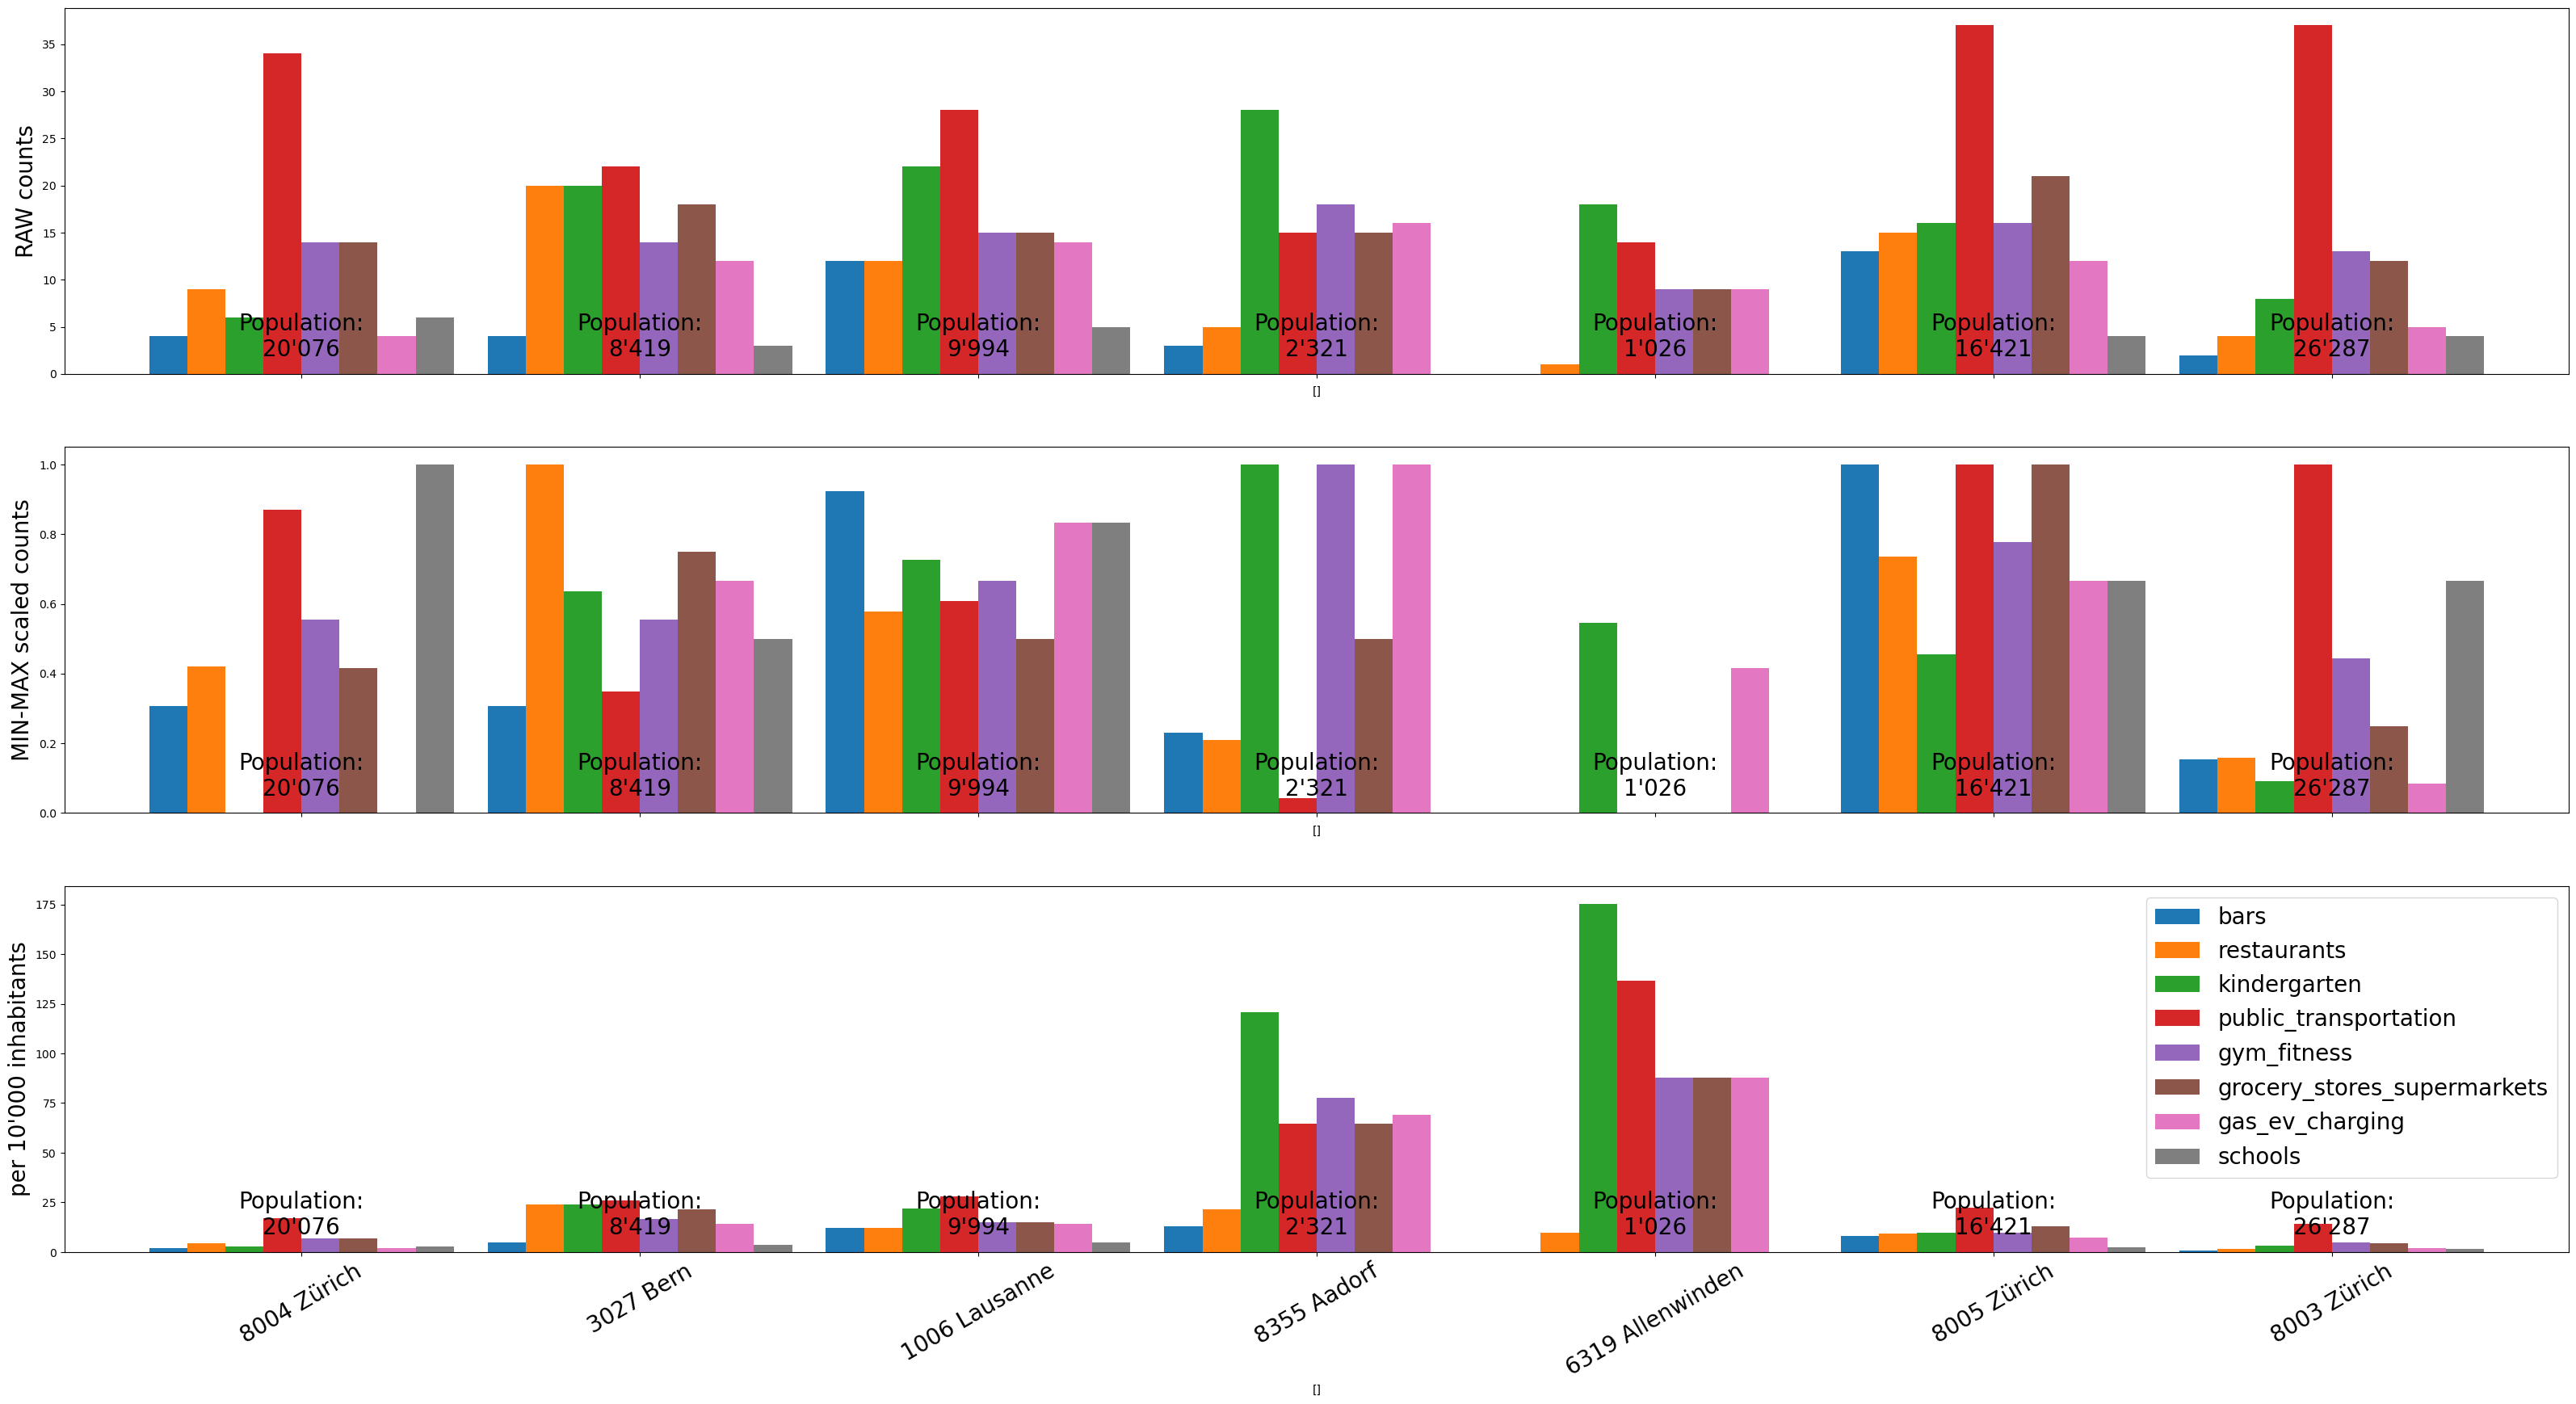

In [22]:
fig, axes = plt.subplots(3,1, figsize=(40,20))
ax1, ax2, ax3 = axes

##############################
df = neighborhoods_counts.copy()

df.set_index('zip_city', inplace=True) # to use as x-labels

df.iloc[:,1:].plot(kind='bar', ax = ax1, width = 0.9) # do not plot total_pop (first column)

for i , index in enumerate(df.index):
    total_pop = df.loc[index, 'total_pop']
    ax1.text(i, 0.05 * np.max(df.iloc[:,1:].max())  , f'Population:\n{total_pop:,}'.replace(',', "'"), ha = 'center', fontsize= 20)

ax1.legend().set_visible(False)
ax1.set_xlabel([])
ax1.set_xticklabels([])
ax1.set_ylabel('RAW counts', fontsize= 20)

##############################
df = neighborhoods_MinMax.copy()

df.set_index('zip_city', inplace=True) # to use as x-labels

df.iloc[:,1:].plot(kind='bar', ax = ax2, width = 0.9) # do not plot total_pop (first column)

for i , index in enumerate(df.index):
    total_pop = df.loc[index, 'total_pop']
    ax2.text(i, 0.05 * np.max(df.iloc[:,1:].max())  , f'Population:\n{total_pop:,}'.replace(',', "'"), ha = 'center', fontsize= 20)

ax2.legend().set_visible(False)
ax2.set_xlabel([])
ax2.set_xticklabels([])
ax2.set_ylabel('MIN-MAX scaled counts', fontsize= 20)

##############################
df = neighborhoods_pop.copy()

df.set_index('zip_city', inplace=True) # to use as x-labels

df.iloc[:,1:].plot(kind='bar', ax = ax3, width = 0.9) # do not plot total_pop (first column)

for i , index in enumerate(df.index):
    total_pop = df.loc[index, 'total_pop']
    ax3.text(i, 0.05 * np.max(df.iloc[:,1:].max())  , f'Population:\n{total_pop:,}'.replace(',', "'"), ha = 'center', fontsize= 20)

ax3.legend(fontsize=20)
ax3.set_xlabel([])
ax3.set_ylabel('per 10\'000 inhabitants', fontsize= 20)
plt.xticks(rotation=30,  fontsize= 20) ;

#### Raw Counts

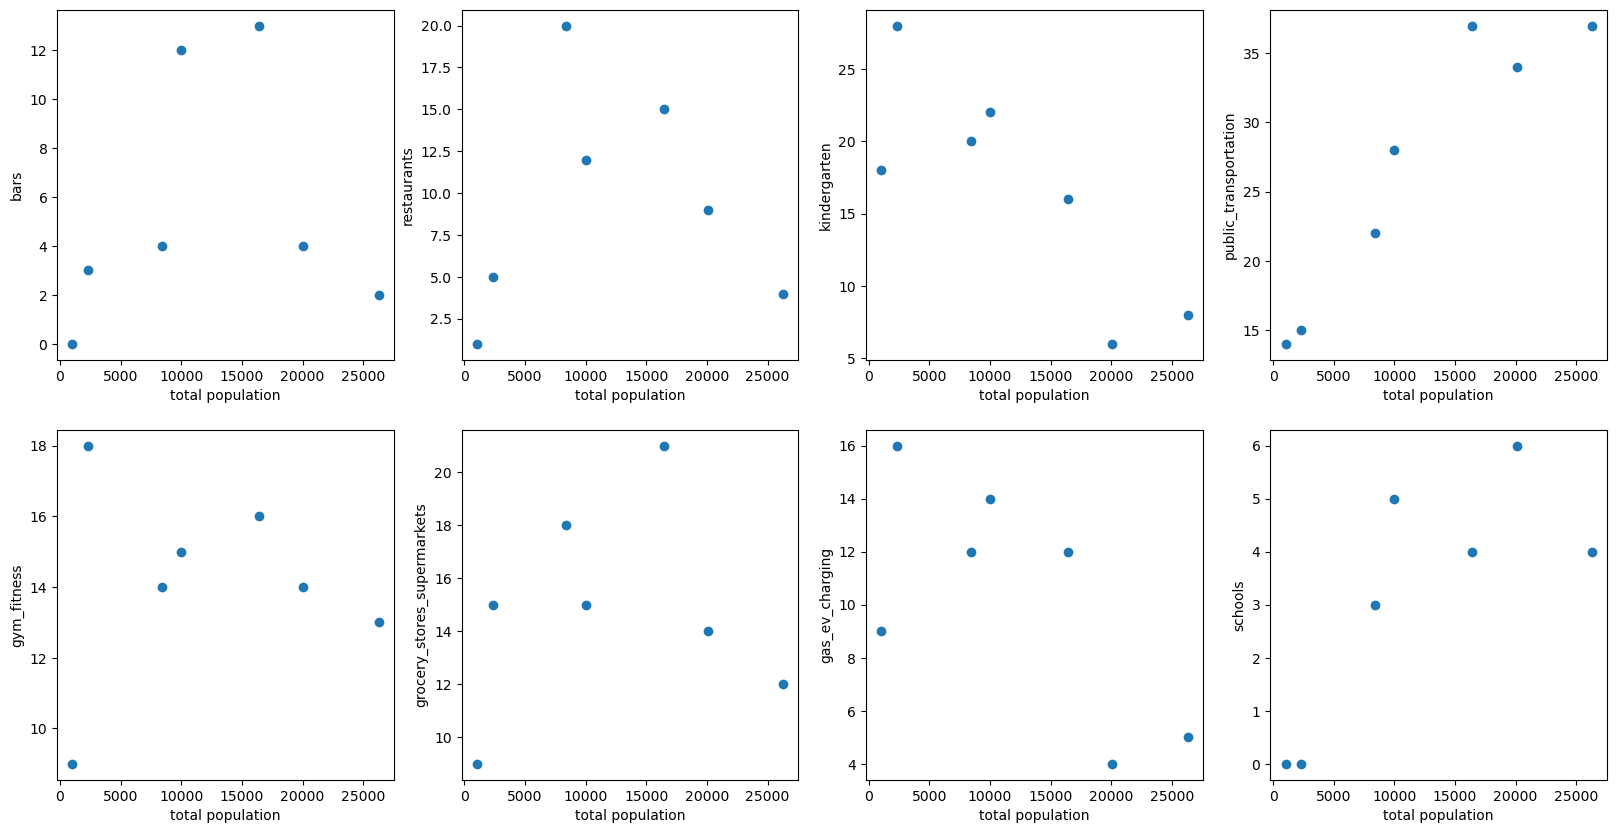

In [23]:
df = neighborhoods_counts.drop(columns='zip_city')
y_cols = [col for col in df.columns if col !='total_pop']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize = (20, 10))
axes = axes.flatten()
for ax, col in zip(axes, y_cols): #not first column which is total_pop, the x column
    ax.scatter(x=df['total_pop'], y=df[col])
    ax.set_xlabel('total population')
    ax.set_ylabel(col)

#### Min-Max scaling

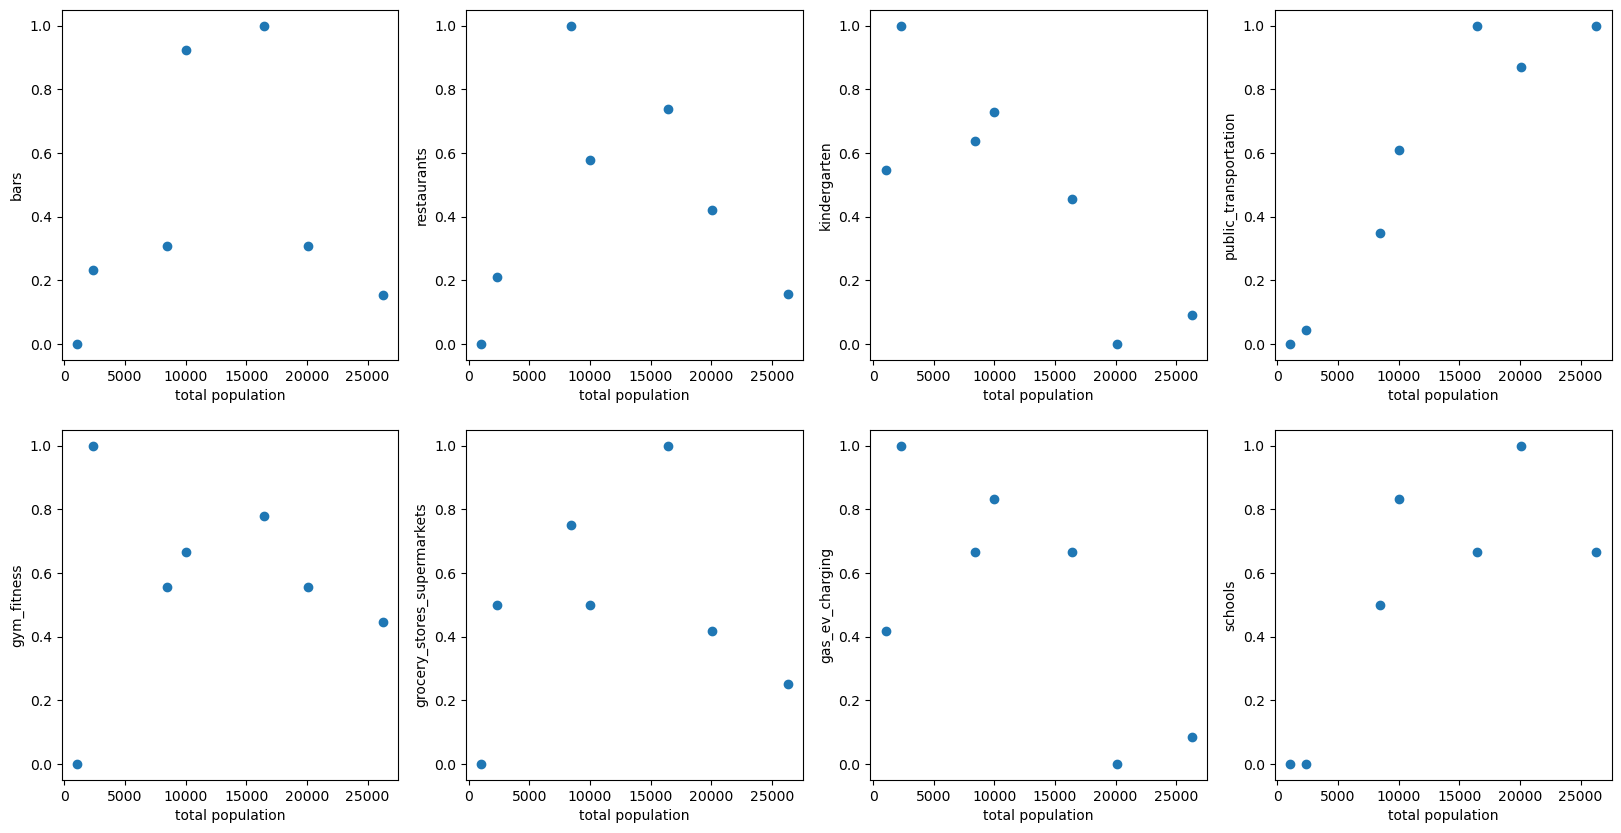

In [24]:
df = neighborhoods_MinMax.drop(columns='zip_city')
y_cols = [col for col in df.columns if col !='total_pop']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize = (20, 10))
axes = axes.flatten()
for ax, col in zip(axes, y_cols): #not first column which is total_pop, the x column
    ax.scatter(x=df['total_pop'], y=df[col])
    ax.set_xlabel('total population')
    ax.set_ylabel(col)

#### per 10'000 inhab.

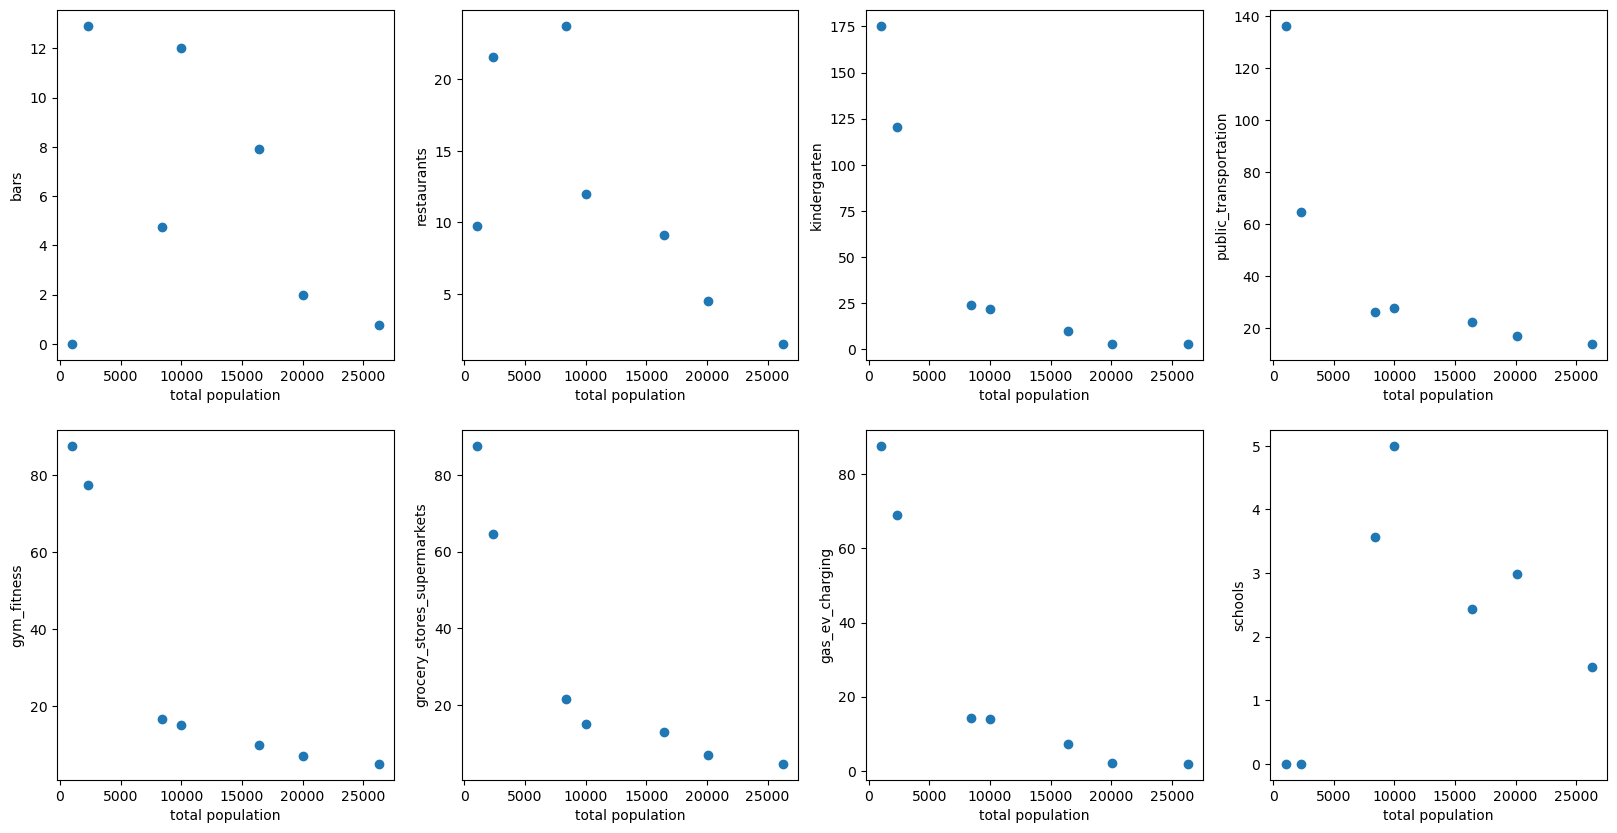

In [25]:
df = neighborhoods_pop.drop(columns='zip_city')
y_cols = [col for col in df.columns if col !='total_pop']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize = (20, 10))
axes = axes.flatten()
for ax, col in zip(axes, y_cols): #not first column which is total_pop, the x column
    ax.scatter(x=df['total_pop'], y=df[col])
    ax.set_xlabel('total population')
    ax.set_ylabel(col)

## Prompting for ChatGPT 

In [27]:
locale.getpreferredencoding = lambda: "UTF-8"

with open('credentials.json', 'r') as file:
    api_creds = yaml.safe_load(file)

openai.api_key = api_creds['openai_key']

### describe_vibe()

In [28]:
def describe_vibe(df, data_type:str):   
    data = df.drop(columns=(['total_pop', 'zip_city']))
    # Define the message for classification
    messages = [
    {"role": "system", "content": """
    You are a data scientist. 
    Your task is to define the atmosphere/vibe of a given neighborhood. 
    A neighborhood is defined as an area reachable with a 10min foot walk around a given real estate property. 
    """},
    {"role": "user", "content": f""" 
    The data given below correspond to the \'{data_type}\' of different amenities types (columns) within each neighborhood (rows). 
    For each neighborhood, return 5 key words describing the atmosphere/vibe of each neighborhood. Justify the choice of each key word must with one short sentence.
    Structure you answer as follows: Neighborhood + row number ; key word 1 - key word 2 - key word 3 - key word 4 - key word 5, + short sentence to justifiy your choice.
    Data: \'{data}\'. 
    """}
    ]

    # Call the OpenAI API with the chat completion endpoint
    response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo-0125",  # advice from Adriano, instead of gpt-3.5-turbo (because of tokens usage)
    messages=messages,
    max_tokens=1000,  
    n=1,
    stop=None,
    temperature=0  # Setting temperature to 0 for deterministic results
    )

    # Extract the classification result from the response
    result = response.choices[0].message['content'].strip()

    # return 'Prompt:\n' + messages[0]['content'] + messages[1]['content'] + '--------\nAnswer: ' + result
    return result

In [29]:
Answer_counts = describe_vibe(neighborhoods_counts, 'number')
Answer_MinMax = describe_vibe(neighborhoods_MinMax, 'min-max scaled number of')
Answer_Pop = describe_vibe(neighborhoods_pop, 'number, per 10\'000 inhabitants,' )

In [30]:
print('------USING THE RAW COUNT OF FACILITIES----------')
for i in range(len(neighborhoods['address'])):
    print('Neighborhood '+ str(i)+': '+ neighborhoods['address'][i])
print('----------------')
print(Answer_counts)
print('\n\n------USING THE COUNT OF FACILITIES, NORMALIZED WITH MIN.-MAX. SCALING----------')
for i in range(len(neighborhoods['address'])):
    print('Neighborhood '+ str(i)+': '+ neighborhoods['address'][i])
print('----------------')
print(Answer_MinMax)
print('\n\n------USING THE COUNT OF FACILITIES, NORMALIZED PER 10\'000 INHABITANTS----------')
for i in range(len(neighborhoods['address'])):
    print('Neighborhood '+ str(i)+': '+ neighborhoods['address'][i])
print('----------------')
print(Answer_Pop)

------USING THE RAW COUNT OF FACILITIES----------
Neighborhood 0: 8004 Zürich, Werdgartengasse 4
Neighborhood 1: 3027 Bern, Colombstrasse 39
Neighborhood 2: 1006 Lausanne, Av. d'Ouchy 58
Neighborhood 3: 8355 Aadorf, Bruggwiesenstrasse 5
Neighborhood 4: 6319 Allenwinden, Winzrüti 39
Neighborhood 5: 8005 Zürich, Heinrichstrasse 200
Neighborhood 6: 8003 Zürich, Birmensdorferstrasse 108
----------------
Neighborhood 0; vibrant - diverse - bustling - convenient - family-friendly,
    Justification:
    - Vibrant: High number of bars, restaurants, and public transportation options suggest a lively and energetic atmosphere.
    - Diverse: Variety of amenities like kindergartens, gyms, and grocery stores indicate a diverse community.
    - Bustling: Presence of multiple amenities like gyms and grocery stores implies a busy and active neighborhood.
    - Convenient: Abundance of public transportation and grocery stores make it convenient for residents.
    - Family-friendly: Presence of kinderg

In [31]:
output = []
output.append('------NEIGHBORHOODS----------\n')
for i in range(len(neighborhoods['address'])):
    output.append('Neighborhood '+ str(i)+': '+ neighborhoods['address'][i])
output.append('\n------USING THE RAW COUNT OF FACILITIES----------\n')
output.append(Answer_counts  +'\n')
output.append('\n------USING THE COUNT OF FACILITIES, NORMALIZED WITH MIN.-MAX. SCALING----------\n')
output.append(Answer_MinMax +'\n')
output.append('\n------USING THE COUNT OF FACILITIES, NORMALIZED PER 10\'000 INHABITANTS----------\n')
output.append(Answer_Pop +'\n' )

output_text = '\n'.join(output)

with open('Neighborhood_vibe_2.txt', 'w') as file:
    file.write(output_text)

### describe_vibe_with_PopAndAddress()

In [32]:
def describe_vibe_with_PopAndAddress(df, data_type:str):  
    data = df
    # Define the message for classification
    messages = [
    {"role": "system", "content": """
    You are a data scientist. 
    Your task is to define the atmosphere/vibe of a given neighborhood. 
    A neighborhood is defined as an area reachable with a 10min foot walk around a given real estate property. 
    """},
    {"role": "user", "content": f""" 
    The data given below correspond to the \'{data_type}\' of different amenities types (columns) within each neighborhood (rows). 
    Addtionnally, the location (city in Switzerland) is indicated in the column "zip_city" and the number of inhabitants in the neighbborhood in given in the column "total_pop".
    For each neighborhood, taking into consideration the location, the number of inhabitants as well as the number of the different amenities, return 5 key words describing the atmosphere/vibe of each neighborhood. Justify the choice of each key word must with one short sentence.
    Structure you answer as follows: Neighborhood = Column "zip_city" ; key word 1 - key word 2 - key word 3 - key word 4 - key word 5, + short sentence to justifiy your choice.
    Data: \'{data}\'. 
    """}
    ]

    # Call the OpenAI API with the chat completion endpoint
    response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo-0125",  # advice from Adriano, instead of gpt-3.5-turbo (because of tokens usage)
    messages=messages,
    max_tokens=1000,  
    n=1,
    stop=None,
    temperature=0  # Setting temperature to 0 for deterministic results
    )

    # Extract the classification result from the response
    result = response.choices[0].message['content'].strip()

    # return 'Prompt:\n' + messages[0]['content'] + messages[1]['content'] + '--------\nAnswer: ' + result
    return result

In [42]:
Answer_counts = describe_vibe_with_PopAndAddress(neighborhoods_counts, 'number')
Answer_MinMax = describe_vibe_with_PopAndAddress(neighborhoods_MinMax, 'min-max scaled number of')
Answer_Pop = describe_vibe_with_PopAndAddress(neighborhoods_pop, 'number, per 10\'000 inhabitants,' )

In [45]:
print('------USING THE RAW COUNT OF FACILITIES----------\n')
print(Answer_counts)
print('\n\n------USING THE COUNT OF FACILITIES, NORMALIZED WITH MIN.-MAX. SCALING----------\n')
print(Answer_MinMax)
print('\n\n------USING THE COUNT OF FACILITIES, NORMALIZED PER 10\'000 INHABITANTS----------\n')
print(Answer_Pop)

------USING THE RAW COUNT OF FACILITIES----------

Neighborhood = 8004 Zürich; vibrant - diverse - bustling - convenient - lively.
    Justification: With a high number of amenities, a significant population, and a good mix of bars, restaurants, and public transportation, this neighborhood is likely vibrant, diverse, bustling, convenient, and lively.

Neighborhood = 3027 Bern; cultural - culinary - vibrant - community - dynamic.
    Justification: The abundance of restaurants and amenities, along with a sizable population, suggests a cultural, culinary, vibrant, community-oriented, and dynamic atmosphere in this neighborhood.

Neighborhood = 1006 Lausanne; trendy - active - youthful - social - energetic.
    Justification: The high number of amenities, especially schools and kindergartens, coupled with a significant population, indicates a trendy, active, youthful, social, and energetic vibe in this neighborhood.

Neighborhood = 8355 Aadorf; peaceful - family-friendly - quaint - close-

In [46]:
output = []

output.append('\n------USING THE RAW COUNT OF FACILITIES----------\n')
output.append(Answer_counts  +'\n')
output.append('\n------USING THE COUNT OF FACILITIES, NORMALIZED WITH MIN.-MAX. SCALING----------\n')
output.append(Answer_MinMax +'\n')
output.append('\n------USING THE COUNT OF FACILITIES, NORMALIZED PER 10\'000 INHABITANTS----------\n')
output.append(Answer_Pop +'\n' )

output_text = '\n'.join(output)

with open('Neighborhood_vibe_withPop&Location_2.txt', 'w') as file:
    file.write(output_text)

### cluster_neighborhoods_with_pop_address()

In [56]:
def cluster_neighborhoods_with_pop_address(df, data_type:str):  
    data = df
    # Define the message for classification
    messages = [
    {"role": "system", "content": """
    You are a data scientist. 
    Your task is to cluster neighborhoods based on their composition in terms of amenities, population size and location. 
    A neighborhood is defined as an area reachable with a 10min foot walk around a given real estate property.
    The criteria/concepts/ideas used for clustering must be summarized with 3 key words. 
    """},
    {"role": "user", "content": f""" 
    The data given below correspond to the \'{data_type}\' of different amenities types (columns) within each neighborhood (rows). 
    Addtionnally, the location (city in Switzerland) is indicated in the column "zip_city" and the number of inhabitants in the neighbborhood in given in the column "total_pop".
    Taking into consideration the location, the number of inhabitants as well as the number of the different amenities, cluster these neighbborhoods into groups. 
    The criteria/concepts/ideas used for clustering must be summarized with 3 key words.
    The choice of these 3 key words must be justified with a short sentence.
    Structure you answer as follows (group sizes are given only as an example).
    Group 1 = Neighborhood 1 ("zip_city"),  Neighborhood 2 ("zip_city"), Neighborhood 3 ("zip_city"),
    Group 2 = Neighborhood 1 ("zip_city"),  Neighborhood 2 ("zip_city")
    Group 3 = Neighborhood 1 ("zip_city"),  Neighborhood 2 ("zip_city")
    Criteria/concepts/ideas used for clustering:
    key word 1: short sentence to justifiy your choice.
    key word 2: short sentence to justifiy your choice.
    key word 3: short sentence to justifiy your choice.
    Data: \'{data}\'. 
    """}
    ]

    # Call the OpenAI API with the chat completion endpoint
    response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo-0125",  # advice from Adriano, instead of gpt-3.5-turbo (because of tokens usage)
    messages=messages,
    max_tokens=1000,  
    n=1,
    stop=None,
    temperature=0  # Setting temperature to 0 for deterministic results
    )

    # Extract the classification result from the response
    result = response.choices[0].message['content'].strip()

    # return 'Prompt:\n' + messages[0]['content'] + messages[1]['content'] + '--------\nAnswer: ' + result
    return result

In [57]:
Answer_counts = cluster_neighborhoods_with_pop_address(neighborhoods_counts, 'number')
Answer_MinMax = cluster_neighborhoods_with_pop_address(neighborhoods_MinMax, 'min-max scaled number of')
Answer_Pop = cluster_neighborhoods_with_pop_address(neighborhoods_pop, 'number, per 10\'000 inhabitants,' )

output = []

output.append('\n------USING THE RAW COUNT OF FACILITIES----------\n')
output.append(Answer_counts  +'\n')
output.append('\n------USING THE COUNT OF FACILITIES, NORMALIZED WITH MIN.-MAX. SCALING----------\n')
output.append(Answer_MinMax +'\n')
output.append('\n------USING THE COUNT OF FACILITIES, NORMALIZED PER 10\'000 INHABITANTS----------\n')
output.append(Answer_Pop +'\n' )

output_text = '\n'.join(output)

with open('Neighborhood_Clustering_With_PopAndAddress_1.txt', 'w') as file:
    file.write(output_text)

### cluster_neighborhoods_WITHOUT_pop_address()

In [65]:
def cluster_neighborhoods_WITHOUT_pop_address(df, data_type:str):  
    data = df.drop(columns=(['total_pop', 'zip_city']))
    # Define the message for classification
    messages = [
    {"role": "system", "content": """
    You are a data scientist. 
    Your task is to cluster neighborhoods based on their composition in terms of amenities. 
    A neighborhood is defined as an area reachable with a 10min foot walk around a given real estate property.
    The criteria/concepts/ideas used for clustering must be summarized with 3 key words. 
    """},
    {"role": "user", "content": f""" 
    The data given below correspond to the \'{data_type}\' of different amenities types (columns) within each neighborhood (rows). 
    Taking into consideration the number of the different amenities, cluster these neighbborhoods into groups. 
    The criteria/concepts/ideas used for clustering must be summarized with 3 key words.
    The choice of these 3 key words must be justified with a short sentence.
    Structure you answer as follows (group sizes are given only as an example).
    Group 1 = Neighborhood 1 (row number),  Neighborhood 2 (row number), Neighborhood 3 (row number),
    Group 2 = Neighborhood 1 (row number),  Neighborhood 2 (row number)
    Group 3 = Neighborhood 1 (row number),  Neighborhood 2 (row number)
    Criteria/concepts/ideas used for clustering:
    key word 1: short sentence to justifiy your choice.
    key word 2: short sentence to justifiy your choice.
    key word 3: short sentence to justifiy your choice.
    Data: \'{data}\'. 
    """}
    ]

    # Call the OpenAI API with the chat completion endpoint
    response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo-0125",  # advice from Adriano, instead of gpt-3.5-turbo (because of tokens usage)
    messages=messages,
    max_tokens=1000,  
    n=1,
    stop=None,
    temperature=0  # Setting temperature to 0 for deterministic results
    )

    # Extract the classification result from the response
    result = response.choices[0].message['content'].strip()

    # return 'Prompt:\n' + messages[0]['content'] + messages[1]['content'] + '--------\nAnswer: ' + result
    return result

In [66]:
Answer_counts = cluster_neighborhoods_WITHOUT_pop_address(neighborhoods_counts, 'number')
Answer_MinMax = cluster_neighborhoods_WITHOUT_pop_address(neighborhoods_MinMax, 'min-max scaled number of')
Answer_Pop = cluster_neighborhoods_WITHOUT_pop_address(neighborhoods_pop, 'number, per 10\'000 inhabitants,' )

output = []
output.append('------NEIGHBORHOODS----------\n')
for i in range(len(neighborhoods['address'])):
    output.append('Neighborhood '+ str(i+1)+': '+ neighborhoods['address'][i])
output.append('\n------USING THE RAW COUNT OF FACILITIES----------\n')
output.append(Answer_counts  +'\n')
output.append('\n------USING THE COUNT OF FACILITIES, NORMALIZED WITH MIN.-MAX. SCALING----------\n')
output.append(Answer_MinMax +'\n')
output.append('\n------USING THE COUNT OF FACILITIES, NORMALIZED PER 10\'000 INHABITANTS----------\n')
output.append(Answer_Pop +'\n' )

output_text = '\n'.join(output)

with open('Neighborhood_Clustering_WITHOUT_PopAndAddress_3.txt', 'w') as file:
    file.write(output_text)

# END OF NOTEBOOK